# Rats Sightings in Manhattan NYC

## 02. EDA
---
Author: _Zhan Yu_

We are going to aggregate our datasets together bases on zip codes and time(Year and Month). Then we are going to look into Manhattan Rats Sightings from 2010 to 2018 with some outside research. Then we can choose one zip code in Manhattan for our time series model in next notebook.

## Table of Contents
- [Loading Libraries & Data](#Loading-Libraries-&-Data)
- [Data Aggregating](#Data-Aggregating)
- [Outside Research](#Outside-Research)

## Loading Libraries & Data

In [235]:
# Libraries: 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression, LogisticRegression

import warnings
warnings.simplefilter(action="ignore")

In [236]:
# Import datasets:
rats = pd.read_csv('../datasets/rats.csv')
rat_sightings = pd.read_csv('../datasets/rat_sightings.csv')
zip_pop_yr = pd.read_csv('../datasets/zip_pop_yr.csv')
zip_res_yr = pd.read_csv('../datasets/zip_res_yr.csv')

## Data Aggregating

`rats.csv`is our base data set.

In [238]:
rats['inspection_date'] = pd.to_datetime(rats['inspection_date'])
rats.head()

In [242]:
rats.sort_values(by = 'inspection_date', ascending = True, inplace = True)

In [243]:
# Extract the year and month from the data column:
rats['year'] = pd.DatetimeIndex(rats['inspection_date']).year
rats['month'] = pd.DatetimeIndex(rats['inspection_date']).month
rats.head()

,inspection_type,zip_code,inspection_date,year,month
510171,BAIT,10027,2010-01-04 09:25:14,2010,1
510170,BAIT,10031,2010-01-04 10:25:59,2010,1
510169,BAIT,10032,2010-01-04 11:05:30,2010,1
510168,BAIT,10032,2010-01-04 11:45:59,2010,1
510167,INITIAL,10034,2010-01-04 12:56:03,2010,1


In [244]:
# Extract the year-month from the data column:
rats['year_month'] = pd.to_datetime(rats['inspection_date']).dt.to_period('M')
rats.head()

,inspection_type,zip_code,inspection_date,year,month,year_month
510171,BAIT,10027,2010-01-04 09:25:14,2010,1,2010-01
510170,BAIT,10031,2010-01-04 10:25:59,2010,1,2010-01
510169,BAIT,10032,2010-01-04 11:05:30,2010,1,2010-01
510168,BAIT,10032,2010-01-04 11:45:59,2010,1,2010-01
510167,INITIAL,10034,2010-01-04 12:56:03,2010,1,2010-01


In [245]:
# Get dummies from "inspection_type":
rats = pd.concat([rats, pd.get_dummies(rats['inspection_type'])], axis = 1)
rats.head()

,inspection_type,zip_code,inspection_date,year,month,year_month,BAIT,CLEAN_UPS,COMPLIANCE,INITIAL
510171,BAIT,10027,2010-01-04 09:25:14,2010,1,2010-01,1,0,0,0
510170,BAIT,10031,2010-01-04 10:25:59,2010,1,2010-01,1,0,0,0
510169,BAIT,10032,2010-01-04 11:05:30,2010,1,2010-01,1,0,0,0
510168,BAIT,10032,2010-01-04 11:45:59,2010,1,2010-01,1,0,0,0
510167,INITIAL,10034,2010-01-04 12:56:03,2010,1,2010-01,0,0,0,1


From `rat_sightings.csv`, we are going to get a new column called "sighting" which means the number of rats sightings in this zip code at this time period reported to New York City Department of Health and Mental Hygiene (DOHMH).

In [246]:
rat_sightings['created_date'] = pd.to_datetime(rat_sightings['created_date'])
rat_sightings['year'] = pd.DatetimeIndex(rat_sightings['created_date']).year
rat_sightings['month'] = pd.DatetimeIndex(rat_sightings['created_date']).month
rat_sightings['year_month'] = pd.to_datetime(rat_sightings['created_date']).dt.to_period('M')
rat_sightings.head()

,incident_zip,created_date,year,month,year_month
0,10023,2020-03-01 00:32:41,2020,3,2020-03
1,10022,2020-02-29 18:54:40,2020,2,2020-02
2,10024,2020-02-29 16:32:06,2020,2,2020-02
3,10016,2020-02-29 14:31:04,2020,2,2020-02
4,10026,2020-02-29 12:10:43,2020,2,2020-02


In [248]:
rat_sightings['sighting'] = 1
sightings = rat_sightings.groupby(by = ['incident_zip', 'year_month'])[['sighting']].sum().reset_index()
sightings.head()

,incident_zip,year_month,sighting
0,10001,2010-01,3
1,10001,2010-03,1
2,10001,2010-05,2
3,10001,2010-07,3
4,10001,2010-09,3


Before we are merging data frames, we need a common column. 

In [249]:
sightings['zip_year_month'] = sightings['incident_zip'].astype(str)+' '+sightings['year_month'].astype(str)
sightings.head()

,incident_zip,year_month,sighting,zip_year_month
0,10001,2010-01,3,10001 2010-01
1,10001,2010-03,1,10001 2010-03
2,10001,2010-05,2,10001 2010-05
3,10001,2010-07,3,10001 2010-07
4,10001,2010-09,3,10001 2010-09


In [250]:
rats_year_month = rats.groupby(by = ['zip_code', 'year_month'])[['BAIT', 'CLEAN_UPS', 'COMPLIANCE', 'INITIAL']].sum().reset_index()
rats_year_month.head()

,zip_code,year_month,BAIT,CLEAN_UPS,COMPLIANCE,INITIAL
0,10001,2010-01,0.0,0.0,15.0,3.0
1,10001,2010-02,1.0,0.0,0.0,3.0
2,10001,2010-03,1.0,0.0,4.0,5.0
3,10001,2010-04,0.0,0.0,2.0,1.0
4,10001,2010-05,3.0,0.0,2.0,62.0


In [251]:
rats_year_month['zip_year_month'] = rats_year_month['zip_code'].astype(str)+' '+rats_year_month['year_month'].astype(str)
rats_year_month.head()

,zip_code,year_month,BAIT,CLEAN_UPS,COMPLIANCE,INITIAL,zip_year_month
0,10001,2010-01,0.0,0.0,15.0,3.0,10001 2010-01
1,10001,2010-02,1.0,0.0,0.0,3.0,10001 2010-02
2,10001,2010-03,1.0,0.0,4.0,5.0,10001 2010-03
3,10001,2010-04,0.0,0.0,2.0,1.0,10001 2010-04
4,10001,2010-05,3.0,0.0,2.0,62.0,10001 2010-05


In [252]:
# Merge two data frames:
zip_year_month = pd.merge(rats_year_month, 
                          sightings, 
                          left_on=rats_year_month['zip_year_month'],       # Common column "zip_year_month"
                          right_on=sightings['zip_year_month'], 
                          how='left')
zip_year_month.head()

,key_0,zip_code,year_month_x,BAIT,CLEAN_UPS,COMPLIANCE,INITIAL,zip_year_month_x,incident_zip,year_month_y,sighting,zip_year_month_y
0,10001 2010-01,10001,2010-01,0.0,0.0,15.0,3.0,10001 2010-01,10001.0,2010-01,3.0,10001 2010-01
1,10001 2010-02,10001,2010-02,1.0,0.0,0.0,3.0,10001 2010-02,NaN,NaT,NaN,NaN
2,10001 2010-03,10001,2010-03,1.0,0.0,4.0,5.0,10001 2010-03,10001.0,2010-03,1.0,10001 2010-03
3,10001 2010-04,10001,2010-04,0.0,0.0,2.0,1.0,10001 2010-04,NaN,NaT,NaN,NaN
4,10001 2010-05,10001,2010-05,3.0,0.0,2.0,62.0,10001 2010-05,10001.0,2010-05,2.0,10001 2010-05


In [253]:
zip_year_month = zip_year_month[['zip_code', 'year_month_x', 'BAIT', 'CLEAN_UPS', 'COMPLIANCE', 'INITIAL', 'sighting', 'zip_year_month_x']]
zip_year_month.columns = zip_year_month.columns.str.lower()
zip_year_month.rename(columns={'year_month_x': 'year_month', 'zip_year_month_x': 'zip_year_month'}, inplace=True)
zip_year_month = zip_year_month.fillna(0)
zip_year_month.head()

,zip_code,year_month,bait,clean_ups,compliance,initial,sighting,zip_year_month
0,10001,2010-01,0.0,0.0,15.0,3.0,3.0,10001 2010-01
1,10001,2010-02,1.0,0.0,0.0,3.0,0.0,10001 2010-02
2,10001,2010-03,1.0,0.0,4.0,5.0,1.0,10001 2010-03
3,10001,2010-04,0.0,0.0,2.0,1.0,0.0,10001 2010-04
4,10001,2010-05,3.0,0.0,2.0,62.0,2.0,10001 2010-05


In [256]:
zip_year_month['zip_year'] = zip_year_month['zip_year_month'].apply(lambda x: x[:10])
zip_year_month.head()

,zip_code,year_month,bait,clean_ups,compliance,initial,sighting,zip_year_month,zip_year
0,10001,2010-01,0.0,0.0,15.0,3.0,3.0,10001 2010-01,10001 2010
1,10001,2010-02,1.0,0.0,0.0,3.0,0.0,10001 2010-02,10001 2010
2,10001,2010-03,1.0,0.0,4.0,5.0,1.0,10001 2010-03,10001 2010
3,10001,2010-04,0.0,0.0,2.0,1.0,0.0,10001 2010-04,10001 2010
4,10001,2010-05,3.0,0.0,2.0,62.0,2.0,10001 2010-05,10001 2010


Merge the "restaurant count" data frame:

In [257]:
exogenous = pd.merge(zip_year_month, 
                     zip_res_yr, 
                     left_on=zip_year_month['zip_year'],     # Common column "zip_year"
                     right_on=zip_res_yr['zip_year'], 
                     how='left')
exogenous.head()

,key_0,zip_code,year_month,bait,clean_ups,compliance,initial,sighting,zip_year_month,zip_year_x,zip_year_y,count
0,10001 2010,10001,2010-01,0.0,0.0,15.0,3.0,3.0,10001 2010-01,10001 2010,10001 2010,410.0
1,10001 2010,10001,2010-02,1.0,0.0,0.0,3.0,0.0,10001 2010-02,10001 2010,10001 2010,410.0
2,10001 2010,10001,2010-03,1.0,0.0,4.0,5.0,1.0,10001 2010-03,10001 2010,10001 2010,410.0
3,10001 2010,10001,2010-04,0.0,0.0,2.0,1.0,0.0,10001 2010-04,10001 2010,10001 2010,410.0
4,10001 2010,10001,2010-05,3.0,0.0,2.0,62.0,2.0,10001 2010-05,10001 2010,10001 2010,410.0


In [258]:
# Get the columns we want:
exogenous = exogenous[['zip_code', 'year_month', 'bait', 'clean_ups', 'compliance', 'initial', 
                       'sighting', 'zip_year_x', 'count']]

In [259]:
# Create the common column for merging:
zip_pop_yr['zip_year'] = zip_pop_yr['zipcode'].astype(str) + ' ' + zip_pop_yr['year'].astype(str)
zip_pop_yr.head()

,zipcode,population,year,zip_year
0,10278,0,2010,10278 2010
1,10280,7853,2010,10280 2010
2,10282,4783,2010,10282 2010
3,10463,65665,2010,10463 2010
4,10001,18949,2010,10001 2010


In [260]:
exogenous = pd.merge(exogenous, 
                     zip_pop_yr, 
                     left_on=exogenous['zip_year_x'],  
                     right_on=zip_pop_yr['zip_year'],  # Common column "zip_year"
                     how='left')
exogenous.head()

,key_0,zip_code,year_month,bait,clean_ups,compliance,initial,sighting,zip_year_x,count,zipcode,population,year,zip_year
0,10001 2010,10001,2010-01,0.0,0.0,15.0,3.0,3.0,10001 2010,410.0,10001.0,18949.0,2010.0,10001 2010
1,10001 2010,10001,2010-02,1.0,0.0,0.0,3.0,0.0,10001 2010,410.0,10001.0,18949.0,2010.0,10001 2010
2,10001 2010,10001,2010-03,1.0,0.0,4.0,5.0,1.0,10001 2010,410.0,10001.0,18949.0,2010.0,10001 2010
3,10001 2010,10001,2010-04,0.0,0.0,2.0,1.0,0.0,10001 2010,410.0,10001.0,18949.0,2010.0,10001 2010
4,10001 2010,10001,2010-05,3.0,0.0,2.0,62.0,2.0,10001 2010,410.0,10001.0,18949.0,2010.0,10001 2010


In [261]:
exogenous = exogenous[['zip_code', 'year_month', 'bait', 'clean_ups', 'compliance', 'initial', 
                       'sighting', 'count', 'population']]
exogenous.head()

,zip_code,year_month,bait,clean_ups,compliance,initial,sighting,count,population
0,10001,2010-01,0.0,0.0,15.0,3.0,3.0,410.0,18949.0
1,10001,2010-02,1.0,0.0,0.0,3.0,0.0,410.0,18949.0
2,10001,2010-03,1.0,0.0,4.0,5.0,1.0,410.0,18949.0
3,10001,2010-04,0.0,0.0,2.0,1.0,0.0,410.0,18949.0
4,10001,2010-05,3.0,0.0,2.0,62.0,2.0,410.0,18949.0


In [262]:
# Clean the data:
exogenous.rename(columns={'count': 'restaurant'}, inplace=True)
exogenous = exogenous.fillna(0)
exogenous.head()

In [265]:
# Export the cleaned data:
exogenous.to_csv('../datasets/exogenous.csv', index=False)

The dataset `exogenous.csv'` had all zip codes in Manhattan with time from 2010-01 to 2018-12 and the columns `restaurant` and `population` are our exogenous features for time series model SARIMAX.

## Outside Research

Rats sighting is highly depending on the temperatures in the city since most of the sightings are outdoor. Let's take a look at Manhattan rats sighting data.

In [269]:
# Rename the data frame:
all_time = exogenous.groupby('year_month')[['sighting']].sum()

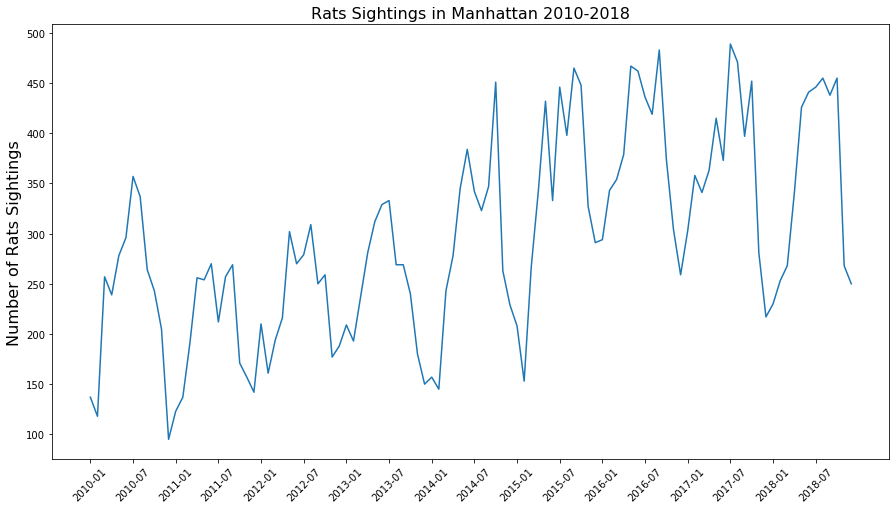

In [287]:
# Plot data.
plt.figure(figsize=(15, 8))
plt.plot(all_time.index.astype(str), all_time)
plt.title(label = 'Rats Sightings in Manhattan 2010-2018', fontsize=16)
plt.ylabel('Number of Rats Sightings', fontsize=16)
plt.xticks(np.arange(0, 108, step=6), rotation=45)
plt.show();

This plot shows the trend of rats sightings in Manhattan, the lowest points are always the winter or cold weather. 

From fiscal year 2012 to fiscal year 2013, pest complaints, including rat problems, increased 10 percent in the city, and 24 percent of the time Health Department workers failed to inspect the complaints in the 10-day target period.   
In July 2017, the New York City government announced a $32 million rat reduction plan in which it initially aimed to reduce rat infestations by 70% by the end of 2018. The plan would alleviate rat infestations in East Village, Chinatown, and the Lower East Side in Lower Manhattan; Concourse in the Bronx; and Bedford–Stuyvesant and Bushwick in Brooklyn. These neighborhoods were chosen because they had high numbers of rat complaints in the past. [Source](https://en.wikipedia.org/wiki/Rats_in_New_York_City)  